# Comparison with SIB on SIR model
SIB: https://www.nature.com/articles/srep27538, https://github.com/sibyl-team/sib

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics
import ProgressMeter;
ProgressMeter.ijulia_behavior(:clear);

In [3]:
using PyCall, SparseArrays

ENV["PYTHON"] = "/home/crotti/miniconda3/bin/python"

@pyimport sib

# convert ϕ's into observations for sib
function sib_SIR_tests(ϕ::Vector{Vector{Vector{F}}}) where {F}
    N = length(ϕ)
    T = length(ϕ[1]) - 1 
    map((i,t) for i in 1:N for t in 1:T+1) do (i,t)
        (i - 1, sib.Test(ϕ[i][t]...), t - 1)
    end
end


function sib_SIR(T::Integer, g::IndexedGraph, ϕ, λ, ρ;
    maxiter=400, tol=1e-14)
    γ = ϕ[1][1][INFECTIOUS]
    @assert all(isequal(γ), ϕᵢ[1][INFECTIOUS] for ϕᵢ in ϕ)
    contacts = [(src(e) - 1, dst(e) - 1, t - 1, λ) for t in 1:T for e in edges(g)]
    append!(contacts, [(dst(e) - 1, src(e) - 1, t - 1, λ) for t in 1:T for e in edges(g)])
    sort!(contacts, by=x -> x[3])
    tests = sib_SIR_tests(ϕ)
    prob_r = sib.PiecewiseLinear(@pycall sib.RealParams([d > 0 ? exp((d-1)*(log(1 - ρ))) : 1.0 for d=0:3T])::Any)
    params = sib.Params(prob_r=prob_r, pseed=γ / (2 - γ), psus=(1 - γ) / (2 - γ), pautoinf=0.0)
    f = sib.FactorGraph(contacts=contacts, tests=tests, params=params)
    sib.iterate(f, maxit=maxiter, tol=tol)
    sib.iterate(f, maxit=maxiter, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxiter, damping=0.9, tol=tol)
    marginals_sib = map(f.nodes) do i
        map(1:T+1) do t
            sib.marginal_t(i, (t - 1))
        end
    end

    F_bethe = -f.loglikelihood() - N * log(2 - γ)

    return marginals_sib, F_bethe, f
end

sib_SIR (generic function with 1 method)

In [4]:
T = 10
N = 30
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.3
ρ = 0.2
γ = 0.1
σ = 0.0 # SIR
sirs = SIRS(g, λ, ρ, σ, T; γ);

In [5]:
bp = mpbp(sirs)

nobs = N
draw_node_observations!(bp, nobs, times=5)
cb = CB_BP(bp);

In [6]:
iters, cb = iterate!(bp, maxiter=100; svd_trunc=TruncBond(4), cb, tol=1e-6);
iters, cb = iterate!(bp, maxiter=100; svd_trunc=TruncBond(6), cb, tol=1e-6);
iters, cb = iterate!(bp, maxiter=100; svd_trunc=TruncBond(8), cb, tol=1e-6);

Running MPBP: iter 2    Time: 0:00:22
  Δ:                0.8221678307634843




Running MPBP: iter 3    Time: 0:00:23
  Δ:                0.5313605671751254




Running MPBP: iter 4    Time: 0:00:23
  Δ:                0.2680990711027913




Running MPBP: iter 5    Time: 0:00:23
  Δ:                0.0470395921994371




Running MPBP: iter 6    Time: 0:00:24
  Δ:                0.001095754445598729




Running MPBP: iter 7    Time: 0:00:24
  Δ:                1.2345227541121773e-5




Running MPBP: iter 8    Time: 0:00:25
  Δ:                1.7208318199291028e-6




Running MPBP: iter 9    Time: 0:00:25
  Δ:                2.7916744249623093e-8




Running MPBP: iter 10    Time: 0:00:26
  Δ:                0.0018608499947203594




Running MPBP: iter 11    Time: 0:00:29
  Δ:                0.0005550895303179093




Running MPBP: iter 12    Time: 0:00:31
  Δ:                0.0001362169522978185




Running MPBP: iter 13    Time: 0:00:33
  Δ:                1.2304445450750379e-5




Running MPBP: iter 14    Time: 0:00:35
  Δ:                1.527715554061615e-6




Running MPBP: iter 15    Time: 0:00:37
  Δ:                4.3494798429577486e-8




Running MPBP: iter 16    Time: 0:00:42
  Δ:                9.77354319724455e-5




Running MPBP: iter 17    Time: 0:00:49
  Δ:                1.5815860384682523e-5




Running MPBP: iter 18    Time: 0:00:57
  Δ:                3.0945778317637007e-6




Running MPBP: iter 19    Time: 0:01:05
  Δ:                9.845242421313571e-8


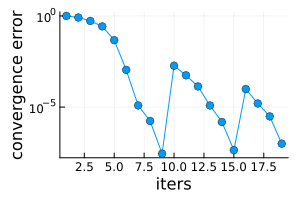

In [7]:
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", m=:o, yaxis=:log10,
    size=(300, 200), label="")

In [8]:
fe_bp = bethe_free_energy(bp)
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

Run sib

In [9]:
b_sib, fe_sib, f = sib_SIR(T, g, bp.ϕ, λ, ρ);

sib.iterate(damp=0.0): 7/400 7.772e-15/1e-14      
sib.iterate(damp=0.5): 1/400 6.328e-15/1e-14      


In [10]:
p_sib = [[bbb[2] for bbb in bb] for bb in b_sib];

In [11]:
[(p_bp[1][t], p_sib[1][t]) for t = 1:T]

10-element Vector{Tuple{Float64, Float64}}:
 (0.03348503804188797, 0.021133717433398425)
 (0.0657695951862233, 0.050828128076081835)
 (0.18552707503272065, 0.17060658152000518)
 (0.4618769337104289, 0.4515249693538852)
 (0.9999999999999998, 1.0)
 (0.8000009103699692, 0.7999999999999999)
 (0.6400018577125925, 0.6399999999999999)
 (0.5120014524157283, 0.512)
 (0.4096011619325833, 0.4096000000000001)
 (0.3276809295460669, 0.3276800000000001)

In [12]:
pl_sib = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:1:T-1, title="sib", yrange=(0, 1))
for i in 1:N
    plot!(pl_sib, 0:T-1, p_sib[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:1:T-1, title="MPdBP", yrange=(0, 1))
for i in 1:N
    plot!(pl_bp, 0:T-1, p_bp[i][1:T], label="i=$i", m=:o, ms=3, lw=1, yrange=[0, 1])
end
println("SI on random regular graph N=$N, k=$k. P(S→I)=$λ.")
println("$nobs random observations.")
#println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
pl_sc = scatter(reduce(vcat, [p[1:end-1] for p in p_bp]), reduce(vcat, p_sib), xlabel="MPdBP",
    ylabel="sib", label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright, xrange=(0, 1), yrange=(0, 1))
plot!(pl_sc, identity, label="", size=(300, 300))
plot(pl_sib, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright,
    margin=5Plots.mm, layout=(1, 3))

SI on random regular graph N=30, k=3. P(S→I)=0.3.
30 random observations.


Compare estimates for the free energy

In [13]:
fe_bp, fe_sib

(10.6195652084469, 16.063551464373067)

In [14]:
(fe_bp - fe_sib) / fe_sib

-0.3389030295075309